In [121]:
import re
import unicodedata
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import env
from sklearn.model_selection import train_test_split
import acquire as a
import prepare as p

# 1. Load the spam data set.

In [5]:
query = 'SELECT * FROM spam'
connection = env.get_db_url('spam_db')
spam = pd.read_sql(query, connection, index_col='id')

In [6]:
spam.head()

label                                               text
id                                                         
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...

In [16]:
def train_split(df):
    train_validate, test = train_test_split(df,
                                            random_state=1349,
                                            train_size=0.8,
                                           stratify=df.label)
    train, validate = train_test_split(train_validate,
                                       random_state=1349,
                                       train_size=0.7,
                                      stratify=train_validate.label)
    return train, validate, test

In [180]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    print(type(text))
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [18]:
train, validate, test = train_split(spam)
spam.shape, train.shape, validate.shape, test.shape

((5572, 2), (3119, 2), (1338, 2), (1115, 2))

In [176]:
train.head()

label                                               text
id                                                           
4803   ham  Er, hello, things didnÛ÷t quite go to plan Û...
4345   ham           You still around? I could use a half-8th
4218   ham       Anything lor if they all go then i go lor...
1876   ham                  Watching tv now. I got new job :)
4052   ham                   I was slept that time.you there?

In [182]:
type(train['text'])

pandas.core.series.Series

In [181]:
ham_df = clean(' '.join(train[train.label == 'ham']['text']))
spam_df = clean(' '.join(train[train.label == 'spam']['text']))
all_df = clean(' '.join(train['text']))

<class 'str'>
<class 'str'>
<class 'str'>


In [190]:
type(ham_df[:5])

list

# 2. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [58]:
# create bigrams
ham_bigrams = nltk.ngrams(ham_df, 2)
spam_bigrams = nltk.ngrams(spam_df, 2)
all_bigrams = nltk.ngrams(all_df, 2)

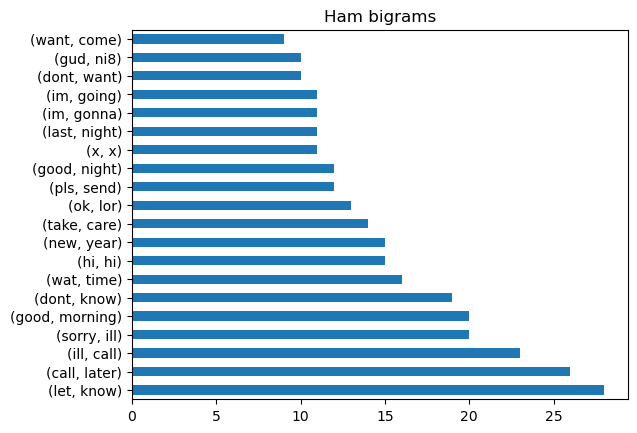

In [59]:
pd.Series(ham_bigrams).value_counts().head(20).plot.barh(title='Ham bigrams');

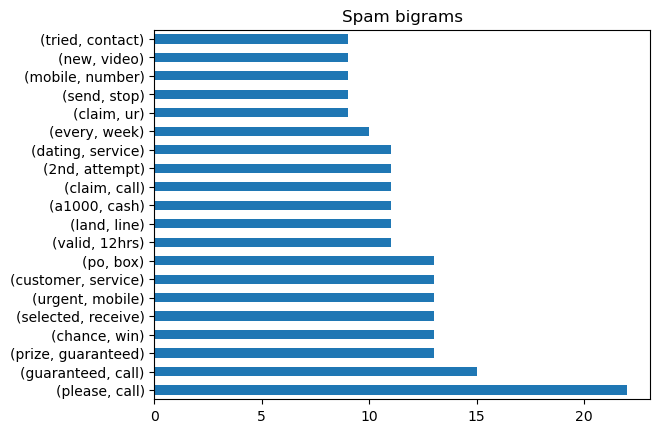

In [60]:
pd.Series(spam_bigrams).value_counts().head(20).plot.barh(title='Spam bigrams');

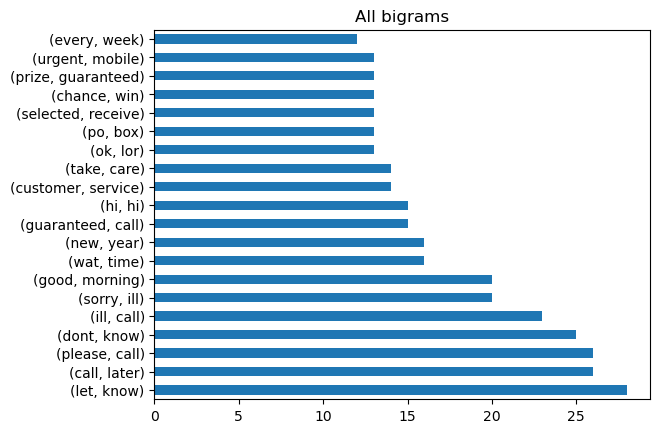

In [61]:
pd.Series(all_bigrams).value_counts().head(20).plot.barh(title='All bigrams');

In [62]:
ham_grams = [thing[0] + '_' + thing[1] for thing in list(nltk.bigrams(ham_df))]
spam_grams = [thing[0] + '_' + thing[1] for thing in list(nltk.bigrams(spam_df))]
all_grams = [thing[0] + '_' + thing[1] for thing in list(nltk.bigrams(all_df))]

In [69]:
type(ham_grams[:5])

list

In [65]:
spam_grams[:5]

['2p_per', 'per_min', 'min_call', 'call_germany', 'germany_08448350055']

In [72]:
all_grams[:5]

['er_hello', 'hello_thing', 'thing_didnut', 'didnut_quite', 'quite_go']

In [75]:
' '.join(all_grams[:4])

'er_hello hello_thing thing_didnut didnut_quite'

In [85]:
all_cloud = WordCloud(background_color='white',
                      height=1000, width=400).generate(' '.join(all_grams))
ham_cloud = WordCloud(background_color='white',
                      height=600, width=1000).generate(' '.join(ham_grams))
spam_cloud = WordCloud(background_color='white',
                       height=600, width=1000).generate(' '.join(spam_grams))

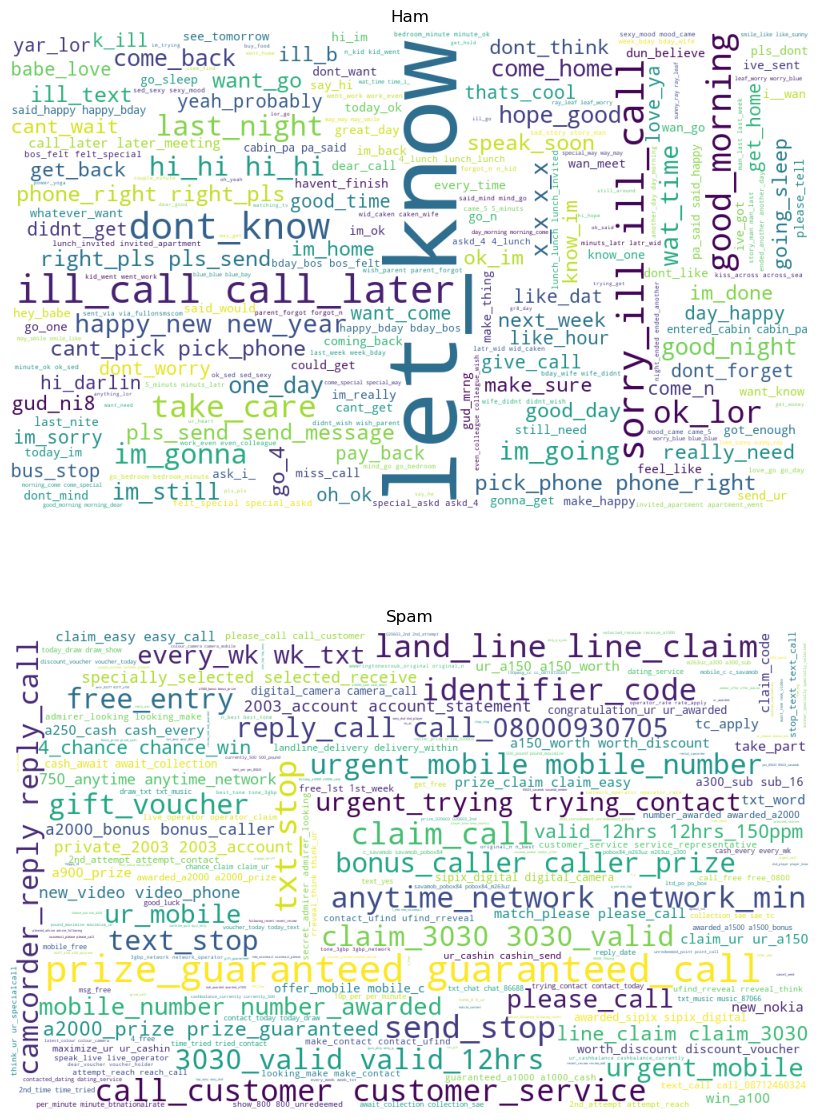

In [91]:

plt.figure(figsize=(16, 12))
axs = [plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(ham_cloud)
axs[1].imshow(spam_cloud)

axs[0].set_title('Ham')
axs[1].set_title('Spam')

for ax in axs: ax.axis('off')


### How do the spam bigrams compare with the ham bigrams?

The ham bigrams have a lot more first person language (im, ill), there are more greetings and salutations, along with much more familair language. The spam bigrams mention prizes and claiming far more, along with urgency and requests for contact.

## 3. Is there any overlap in the bigrams for the spam data and the ham data?

In [97]:
pd.Series(all_grams)

0             er_hello
1          hello_thing
2         thing_didnut
3         didnut_quite
4             quite_go
             ...      
28490       themob_wap
28491     wap_bookmark
28492    bookmark_text
28493         text_wap
28494        wap_82468
Length: 28495, dtype: object

In [98]:
bigram_counts = (pd.concat([pd.Series(all_grams).value_counts(),
                            pd.Series(ham_grams).value_counts(),
                            pd.Series(spam_grams).value_counts()
                            ], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

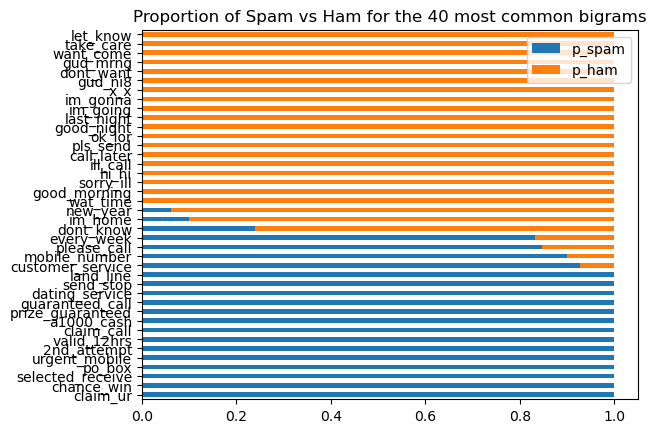

In [111]:
# figure out the percentage of spam vs ham
(bigram_counts
 .assign(p_spam=bigram_counts.spam / bigram_counts['all'],
         p_ham=bigram_counts.ham / bigram_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(40)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 40 most common bigrams');

In [106]:
bigram_counts

all  ham  spam
0089my_last            1    0     1
01223585236_xx         1    0     1
0125698789_ring        1    1     0
020603_2nd             4    0     4
02070836089_kit        0    0     1
...                  ...  ...   ...
zebra_animation        1    0     1
zed_08701417012150p    1    0     1
zero_saving            1    1     0
zhong_se               1    1     0
zoe_hit                1    1     0

[24107 rows x 3 columns]

### There is very little overlap in bigrams between ham and spam

# 4. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [113]:
ham_3grams = [thing[0] + '_' + thing[1] + '_' + thing[2]
              for thing in list(nltk.ngrams(ham_df, 3))]
spam_3grams = [thing[0] + '_' + thing[1] + '_' + thing[2]
               for thing in list(nltk.ngrams(spam_df, 3))]
all_3grams = [thing[0] + '_' + thing[1] + '_' + thing[2]
              for thing in list(nltk.ngrams(all_df, 3))]

In [114]:
all_3grams[:5]

['er_hello_thing',
 'hello_thing_didnut',
 'thing_didnut_quite',
 'didnut_quite_go',
 'quite_go_plan']

In [117]:
all_cloud = WordCloud(background_color='white',
                      height=1000, width=400).generate(' '.join(all_3grams))
ham_cloud = WordCloud(background_color='white',
                      height=600, width=1000).generate(' '.join(ham_3grams))
spam_cloud = WordCloud(background_color='white',
                       height=600, width=1000).generate(' '.join(spam_3grams))

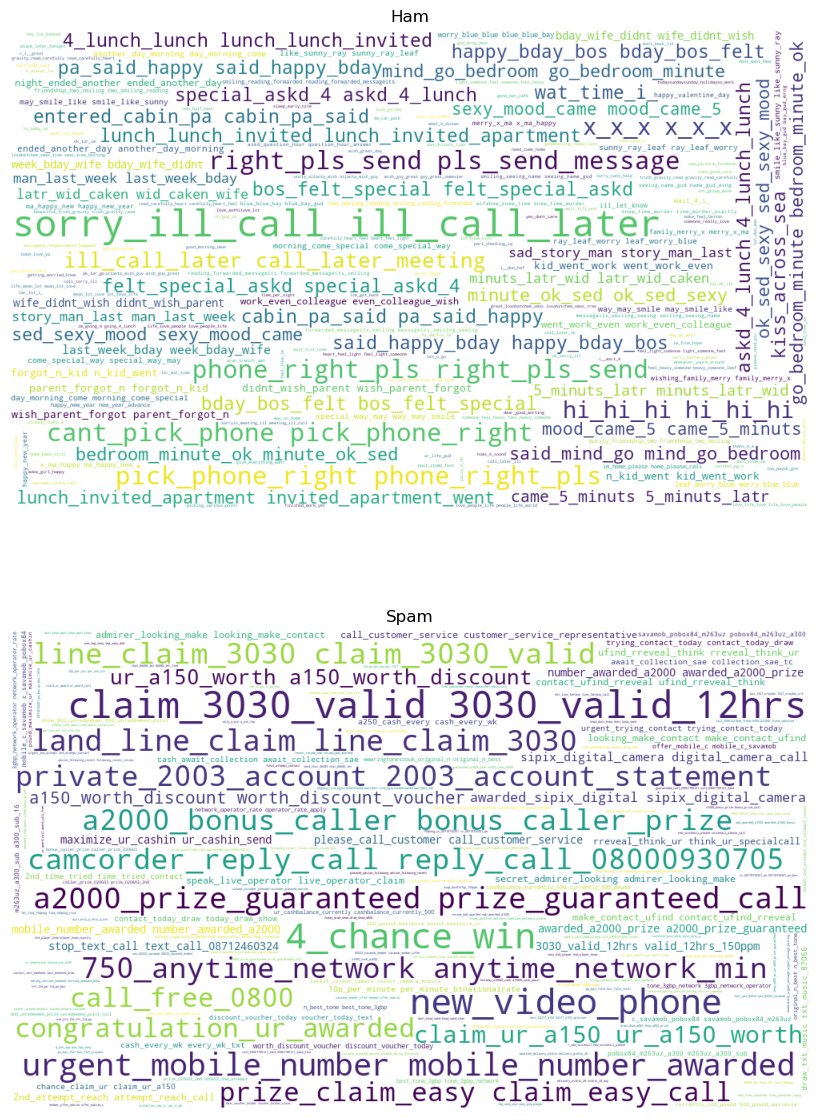

In [118]:
plt.figure(figsize=(16, 12))
axs = [plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(ham_cloud)
axs[1].imshow(spam_cloud)

axs[0].set_title('Ham')
axs[1].set_title('Spam')

for ax in axs: ax.axis('off')

In [119]:
trigram_counts = (pd.concat([pd.Series(all_3grams).value_counts(),
                            pd.Series(ham_3grams).value_counts(),
                            pd.Series(spam_3grams).value_counts()
                            ], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

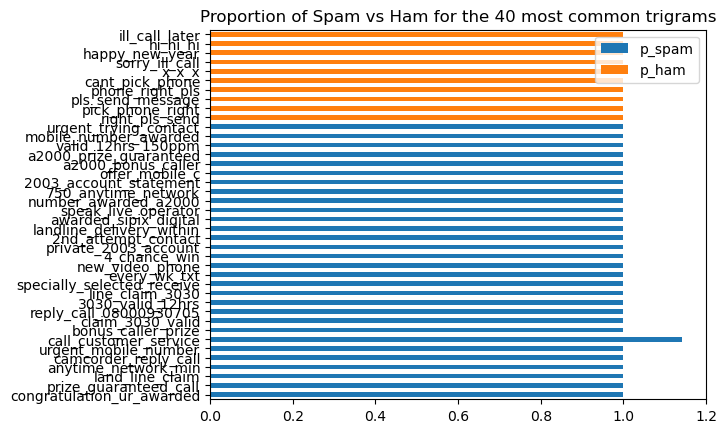

In [120]:
# figure out the percentage of spam vs ham
(trigram_counts
 .assign(p_spam=trigram_counts.spam / trigram_counts['all'],
         p_ham=trigram_counts.ham / trigram_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(40)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 40 most common trigrams');

# Part 2

## Explore the blog articles using the techniques discussed in the exploration lesson.

In [122]:
blogs = a.get_blog_articles()

Opening file codeup_blogs.csv from local directory


In [123]:
blogs = p.prepare_articles(blogs)

In [175]:
blogs.head()

title  \
0  Women in tech: Panelist Spotlight – Magdalena ...   
1  Women in tech: Panelist Spotlight – Rachel Rob...   
2   Women in Tech: Panelist Spotlight – Sarah Mellor   
3  Women in Tech: Panelist Spotlight – Madeleine ...   
4  Black Excellence in Tech: Panelist Spotlight –...   

                                            original  \
0  \nCodeup is hosting a Women in Tech Panel in h...   
1  \nCodeup is hosting a Women in Tech Panel in h...   
2   \nCodeup is hosting a Women in Tech Panel in ...   
3  \nCodeup is hosting a Women in Tech Panel in h...   
4  \n\nCodeup is hosting a Black Excellence in Te...   

                                               clean  \
0  codeup hosting women tech panel honor womens h...   
1  codeup hosting women tech panel honor womens h...   
2  codeup hosting women tech panel honor womens h...   
3  codeup hosting women tech panel honor womens h...   
4  codeup hosting black excellence tech panel hon...   

                                             stemmed  \
0  codeup host women tech panel honor women histo...   
1  codeup host women tech panel honor women histo...   
2  codeup host women tech panel honor women histo...   
3  codeup host women tech panel honor women histo...   
4  codeup host black excel tech panel honor black...   

                                          lemmatized  \
0  codeup hosting woman tech panel honor woman hi...   
1  codeup hosting woman tech panel honor woman hi...   
2  codeup hosting woman tech panel honor woman hi...   
3  codeup hosting woman tech panel honor woman hi...   
4  codeup hosting black excellence tech panel hon...   

                                                 url  
0  https://codeup.com/featured/women-in-tech-pane...  
1  https://codeup.com/featured/women-in-tech-rach...  
2  https://codeup.com/codeup-news/women-in-tech-p...  
3  https://codeup.com/events/women-in-tech-madele...  
4  https://codeup.com/codeup-news/panelist-spotli...

In [126]:
def article_train_split(df):
    train_validate, test = train_test_split(df,
                                            random_state=1349,
                                            train_size=0.8)
    train, validate = train_test_split(train_validate,
                                       random_state=1349,
                                       train_size=0.7)
    return train, validate, test

In [128]:
train_blogs, val_blogs, test_blogs = article_train_split(blogs)

In [177]:
train_blogs.head()

title  \
103        How Codeup Alumni are Helping to Make Water   
98                           What is Machine Learning?   
133        How A Year of Life Change Lead Me To Codeup   
33   What Jobs Can You Get After a Coding Bootcamp?...   
116  15 Tips on How to Prepare For Virtual Intervie...   

                                              original  \
103  Imagine having a kit mailed to you with all th...   
98   There’s a lot we can learn about machines, and...   
133  This time last year I was a college student ma...   
33   If you are interested in embarking on a career...   
116  In response to the spread of COVID-19, many co...   

                                                 clean  \
103  imagine kit mailed necessary components make c...   
98   theres lot learn machines theres lot machines ...   
133  time last year college student majoring kinesi...   
33   interested embarking career tech youre probabl...   
116  response spread covid19 many companies making ...   

                                               stemmed  \
103  imagin kit mail necessari compon make contamin...   
98   there lot learn machin there lot machin learn ...   
133  time last year colleg student major kinesiolog...   
33   interest embark career tech your probabl wonde...   
116  respons spread covid19 mani compani make switc...   

                                            lemmatized  \
103  imagine kit mailed necessary component make co...   
98   there lot learn machine there lot machine lear...   
133  time last year college student majoring kinesi...   
33   interested embarking career tech youre probabl...   
116  response spread covid19 many company making sw...   

                                                   url  
103  https://codeup.com/web-development/codeup-alum...  
98   https://codeup.com/data-science/what-is-machin...  
133  https://codeup.com/alumni-stories/how-a-year-o...  
33   https://codeup.com/data-science/jobs-after-a-c...  
116  https://codeup.com/tips-for-prospective-studen...

In [129]:
blogs.shape, train_blogs.shape, val_blogs.shape, test_blogs.shape

((158, 6), (88, 6), (38, 6), (32, 6))

In [201]:
blog_words = (' '.join(train_blogs['lemmatized'])).split()

In [202]:
blog_words[:10]

['imagine',
 'kit',
 'mailed',
 'necessary',
 'component',
 'make',
 'contaminated',
 'water',
 'clean',
 'cool']

In [212]:
blog_word_freq = pd.concat([pd.Series(blog_words).value_counts(),
                            pd.Series(blog_words).value_counts(normalize=True)],
                           axis=1).rename(columns={0:'count',1:'proba'})

In [213]:
blog_word_freq

count     proba
codeup     362  0.014550
data       305  0.012259
career     246  0.009887
program    199  0.007998
job        189  0.007596
...        ...       ...
52           1  0.000040
racial       1  0.000040
lift         1  0.000040
tide         1  0.000040
wallace      1  0.000040

[4491 rows x 2 columns]

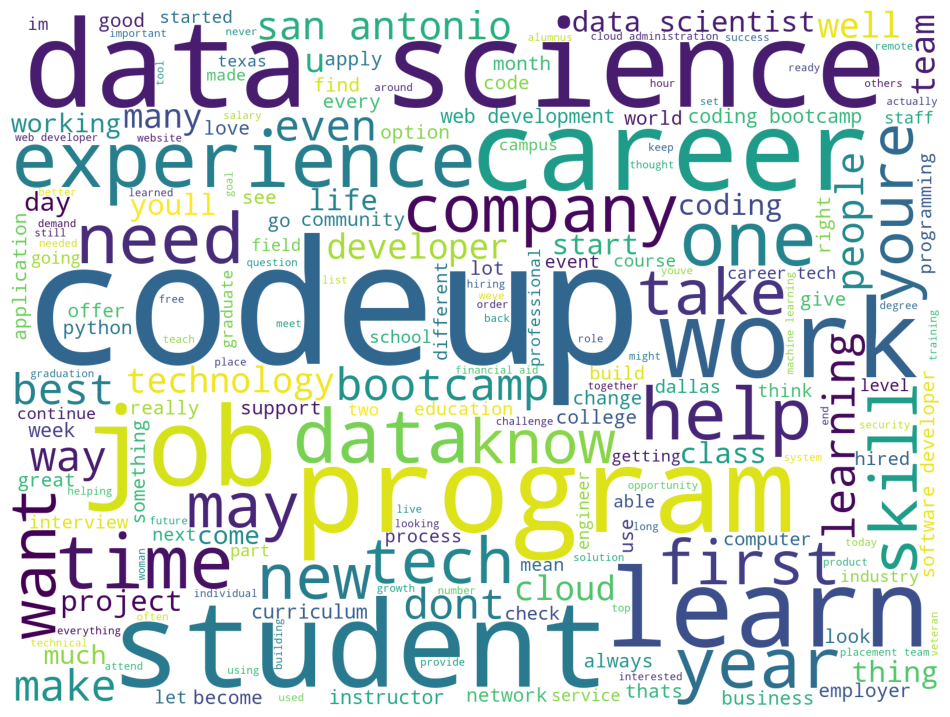

In [218]:
plt.figure(figsize=(12,16))
img = WordCloud(background_color='white',
               height=1200, width=1600).generate(' '.join(blog_words))
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

In [195]:
blog_2grams = [thing[0] + '_' + thing[1] for thing in list(nltk.ngrams(blog_words, 2))]

In [196]:
pd.Series(blog_2grams).value_counts().head()

data_science          146
san_antonio            58
data_scientist         55
web_development        49
software_developer     39
dtype: int64

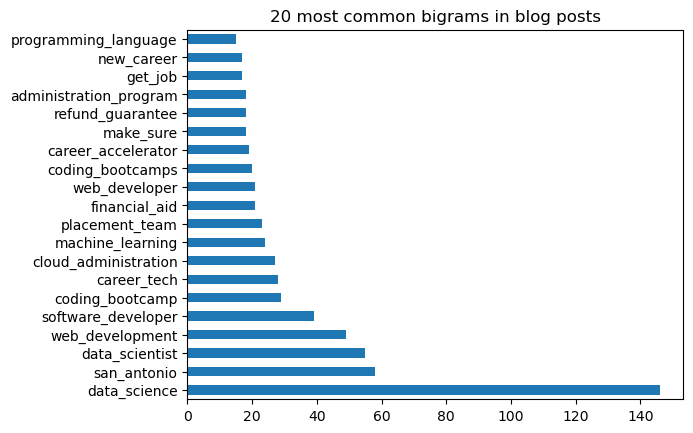

In [199]:
pd.Series(blog_2grams).value_counts().head(20).\
    plot.barh(title='20 most common bigrams in blog posts');

In [221]:
blog_cloud = WordCloud(background_color='white',
                      height=600, width=1000).generate(' '.join(blog_2grams))

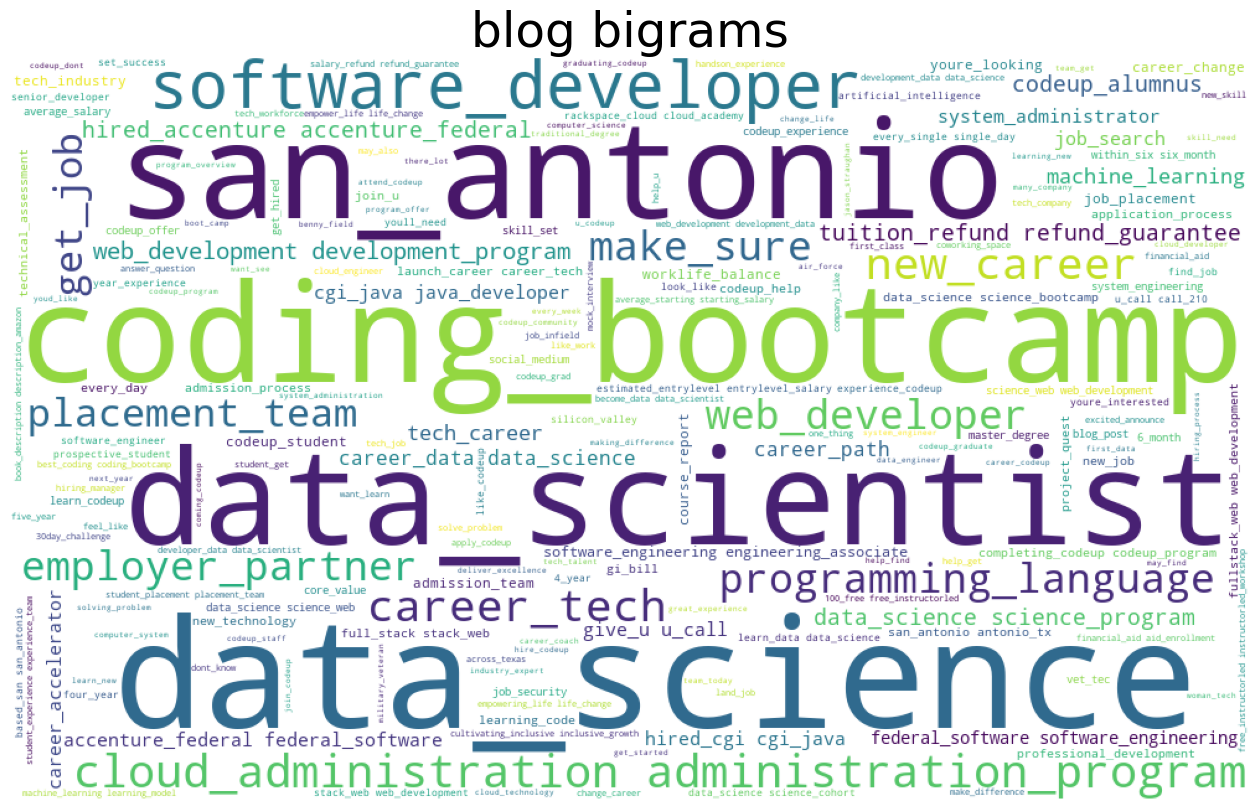

In [225]:
plt.figure(figsize=(16, 12))
plt.imshow(blog_cloud)
plt.title('blog bigrams', size=35)
plt.axis('off')
plt.show()

### Blog trigrams

In [231]:
blog_3grams = [thing[0] + '_' + thing[1] + '_' + thing[2]
               for thing in list(nltk.ngrams(blog_words, 3))]

In [232]:
pd.Series(blog_3grams).value_counts().head()

cloud_administration_program    18
web_development_program         14
tuition_refund_guarantee        13
data_science_program            13
hired_accenture_federal         13
dtype: int64

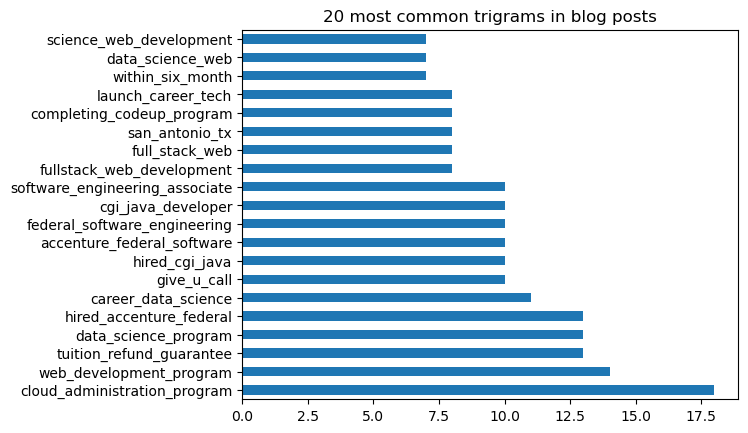

In [233]:
pd.Series(blog_3grams).value_counts().head(20).\
    plot.barh(title='20 most common trigrams in blog posts');

In [234]:
blog_cloud = WordCloud(background_color='white',
                      height=600, width=1000).generate(' '.join(blog_3grams))

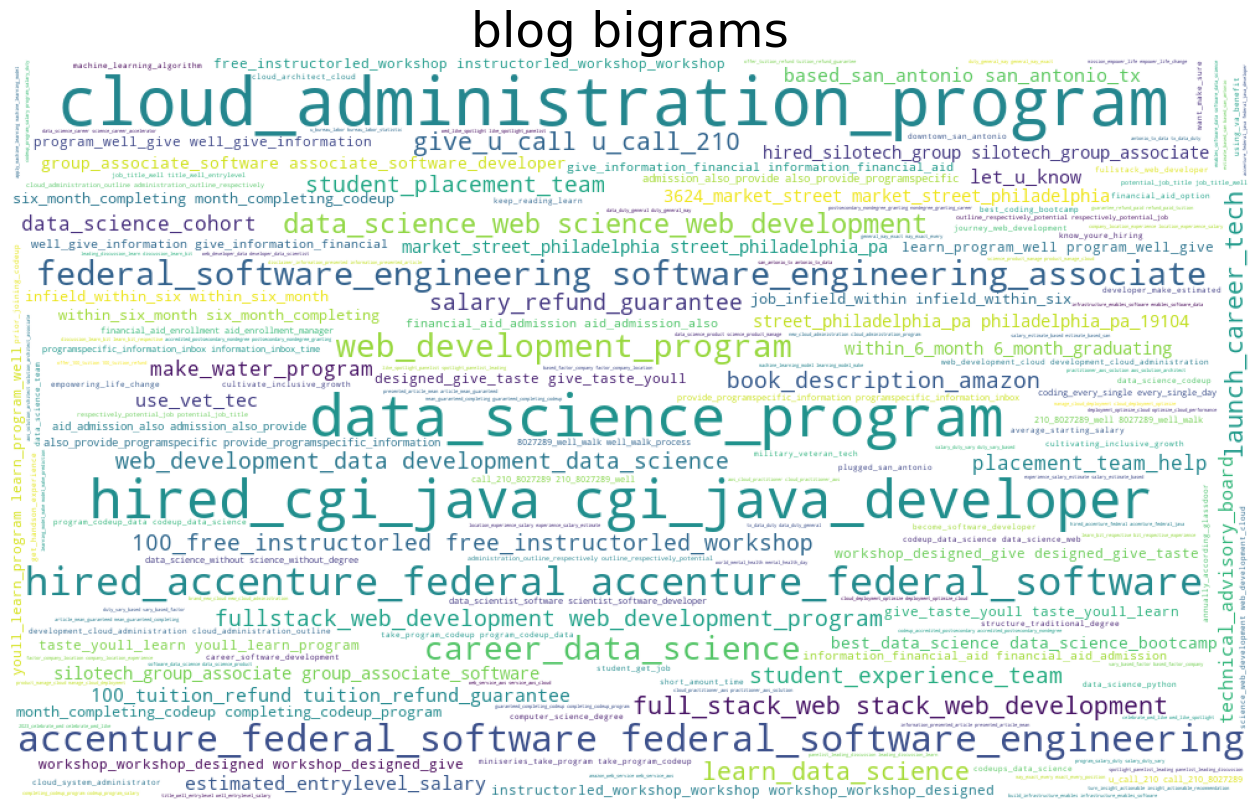

In [235]:
plt.figure(figsize=(16, 12))
plt.imshow(blog_cloud)
plt.title('blog bigrams', size=35)
plt.axis('off')
plt.show()

# Part 3
news articles

In [236]:
news = a.get_news_articles()

Opening news data from local file inshorts_news.csv


In [237]:
news = p.prepare_articles(news)

In [238]:
news.head()

title  \
0  EVMs never sent to SA, expose source of info: ...   
1  73.19% voter turnout in K'taka poll, new recor...   
2  No possibility of 3rd front, BJD will go solo ...   
3  'Mocha' to intensify into severe cyclonic stor...   
4  HC sets up SIT to probe rape & murder of teen ...   

                                            original  \
0  EC has denied Congress MP Randeep Surjewala's ...   
1  Karnataka registered a voter turnout of 73.19%...   
2  After meeting Prime Minister Narendra Modi in ...   
3  Cyclonic storm 'Mocha' over the southeast Bay ...   
4  The Calcutta High Court on Thursday set up a s...   

                                               clean  \
0  ec denied congress mp randeep surjewalas alleg...   
1  karnataka registered voter turnout 7319 assemb...   
2  meeting prime minister narendra modi delhi odi...   
3  cyclonic storm mocha southeast bay bengal expe...   
4  calcutta high court thursday set special inves...   

                                             stemmed  \
0  ec deni congress mp randeep surjewala alleg ev...   
1  karnataka regist voter turnout 7319 assembl po...   
2  meet prime minist narendra modi delhi odisha c...   
3  cyclon storm mocha southeast bay bengal expect...   
4  calcutta high court thursday set special inves...   

                                          lemmatized  \
0  ec denied congress mp randeep surjewalas alleg...   
1  karnataka registered voter turnout 7319 assemb...   
2  meeting prime minister narendra modi delhi odi...   
3  cyclonic storm mocha southeast bay bengal expe...   
4  calcutta high court thursday set special inves...   

                                                 url  category  
0  https://inshorts.com/en/news/evms-never-sent-t...  national  
1  https://inshorts.com/en/news/7319-voter-turnou...  national  
2  https://inshorts.com/en/news/no-possibility-of...  national  
3  https://inshorts.com/en/news/mocha-to-intensif...  national  
4  https://inshorts.com/en/news/hc-sets-up-sit-to...  national

In [240]:
def news_train_split(df):
    train_validate, test = train_test_split(df,
                                            random_state=1349,
                                            train_size=0.8,
                                           stratify=df.category)
    train, validate = train_test_split(train_validate,
                                       random_state=1349,
                                       train_size=0.7,
                                      stratify=train_validate.category)
    return train, validate, test

In [241]:
train_news, val_news, test_news = news_train_split(news)

In [242]:
news.shape, train_news.shape, val_news.shape, test_news.shape

((296, 7), (165, 7), (71, 7), (60, 7))

In [253]:
train_news.head()

title  \
247  World’s heaviest radish weighing 45.865-kg gro...   
118  Speaker should disqualify MLAs: Abhishek Singh...   
217  World's only nonuplets celebrate their 2nd bir...   
94   UK island that inspired Agatha Christie's nove...   
76   Monkeypox no longer a global health emergency,...   

                                              original  \
247  The world's heaviest radish weighing 45.865 kg...   
118  Abhishek Manu Singhvi, who argued for Uddhav T...   
217  The world's first surviving nonuplets celebrat...   
94   An island that inspired some novels by author ...   
76   WHO declared that Monkeypox is no longer a glo...   

                                                 clean  \
247  worlds heaviest radish weighing 45865 kg grown...   
118  abhishek manu singhvi argued uddhav thackeray ...   
217  worlds first surviving nonuplets celebrated se...   
94   island inspired novels author agatha christie ...   
76   declared monkeypox longer global health emerge...   

                                               stemmed  \
247  world heaviest radish weigh 45865 kg grown jap...   
118  abhishek manu singhvi argu uddhav thackeray si...   
217  world first surviv nonuplet celebr second birt...   
94   island inspir novel author agatha christi gone...   
76   declar monkeypox longer global health emerg ye...   

                                            lemmatized  \
247  world heaviest radish weighing 45865 kg grown ...   
118  abhishek manu singhvi argued uddhav thackeray ...   
217  world first surviving nonuplets celebrated sec...   
94   island inspired novel author agatha christie g...   
76   declared monkeypox longer global health emerge...   

                                                   url       category  
247  https://inshorts.com/en/news/worlds-heaviest-r...          hatke  
118  https://inshorts.com/en/news/speaker-should-di...       politics  
217  https://inshorts.com/en/news/worlds-only-nonup...  miscellaneous  
94   https://inshorts.com/en/news/uk-island-that-in...          world  
76   https://inshorts.com/en/news/monkeypox-no-long...          world

In [268]:
train_news.lemmatized

247    world heaviest radish weighing 45865 kg grown ...
118    abhishek manu singhvi argued uddhav thackeray ...
217    world first surviving nonuplets celebrated sec...
94     island inspired novel author agatha christie g...
76     declared monkeypox longer global health emerge...
                             ...                        
17     union minister shobha karandlaje said need ope...
268    researcher found mysterious exoplanet gj 1214 ...
202    west bengal chief minister mamata banerjee sun...
40     amount american filing new claim jobless benef...
232    picture 10room house falling maharashtra telan...
Name: lemmatized, Length: 165, dtype: object

In [297]:
labels = [cat for cat in set(train_news.category)]

In [308]:
news_words_entertainment = (' '.join(
    train_news[train_news.category == 'entertainment']['lemmatized'])).split()
news_words_technology = (' '.join(
    train_news[train_news.category == 'technology']['lemmatized'])).split()
news_words_politics = (' '.join(
    train_news[train_news.category == 'politics']['lemmatized'])).split()
news_words_science = (' '.join(
    train_news[train_news.category == 'science']['lemmatized'])).split()
news_words_national = (' '.join(
    train_news[train_news.category == 'national']['lemmatized'])).split()
news_words_startup = (' '.join(
    train_news[train_news.category == 'startup']['lemmatized'])).split()
news_words_miscellaneous = (' '.join(
    train_news[train_news.category == 'miscellaneous']['lemmatized'])).split()
news_words_world = (' '.join(
    train_news[train_news.category == 'world']['lemmatized'])).split()
news_words_hatke = (' '.join(
    train_news[train_news.category == 'hatke']['lemmatized'])).split()
news_words_business = (' '.join(
    train_news[train_news.category == 'business']['lemmatized'])).split()
news_words_sports = (' '.join(
    train_news[train_news.category == 'sports']['lemmatized'])).split()
news_words_automobile = (' '.join(
    train_news[train_news.category == 'automobile']['lemmatized'])).split()
news_words_all = (' '.join(
    train_news['lemmatized'])).split()

In [310]:
news_words_counts = (pd.concat([
    pd.Series(news_words_entertainment).value_counts(),
    pd.Series(news_words_technology).value_counts(),
    pd.Series(news_words_politics).value_counts(),
    pd.Series(news_words_science).value_counts(),
    pd.Series(news_words_national).value_counts(),
    pd.Series(news_words_startup).value_counts(),
    pd.Series(news_words_miscellaneous).value_counts(),
    pd.Series(news_words_world).value_counts(),
    pd.Series(news_words_hatke).value_counts(),
    pd.Series(news_words_business).value_counts(),
    pd.Series(news_words_sports).value_counts(),
    pd.Series(news_words_automobile).value_counts(),
    pd.Series(news_words_all).value_counts()
        ], axis=1, sort=True)
            .set_axis(labels, axis=1, inplace=False)
            .fillna(0)
            .apply(lambda s: s.astype(int)))

TypeError: can only concatenate list (not "str") to list

In [307]:
news_words_counts.sort_values('entertainment', ascending=False).head()

entertainment  technology  politics  science  national  startup  \
said                15          12        16        2        15        7   
actress              6           0         0        0         0        0   
actor                6           0         1        0         0        0   
added                6           2         5        2         5        5   
time                 5           0         0        2         0        4   

         miscellaneous  world  hatke  business  sports  automobile  
said                 8      9      6         6       7          11  
actress              0      0      0         0       0           0  
actor                0      0      0         0       0           0  
added                0      1      2         1       6           2  
time                 1      1      2         0       2           0

In [284]:
news_word_freq = pd.concat(
    
    [[pd.DataFrame(news_words[news_words.category == cat]).value_counts()
     for cat in set(news.category)]]
    
    ,axis=1).rename(columns={0:'count',1:'proba'})

AttributeError: 'dict' object has no attribute 'category'

In [246]:
news_word_freq

count     proba
said        114  0.019003
added        37  0.006168
video        29  0.004834
court        26  0.004334
company      26  0.004334
...         ...       ...
losing        1  0.000167
weekend       1  0.000167
fulltime      1  0.000167
hundred       1  0.000167
problem       1  0.000167

[2749 rows x 2 columns]